# **Detection of International Flight Delays from Seattle to 453 other contries.**

## Imports and Data conversion from CSV to DataFrame using Pandas

In [12]:
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statistics import median, mode, variance,stdev
from pprint import pprint
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pylab as py
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/DataSets/Flight Delay/DelayedFlights.csv")

Mounted at /content/drive


## Data Preparation Begins here:
1. Checking invalid row (NaN, NA) values, and removing the entire Row related to the same


In [4]:
df.dropna(axis=0,how='any', inplace = True)
df.isna().sum()

Unnamed: 0           0
Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

## Dropping invalid Columns:
  * **Unnamed:0**: This column is just a DataFiller, hence it is dropped.
  * **Cancelled**: This is the column that denotes if a flight is cancelled or not, we are predicting only flight delays and not Cancellation of flights. Hence this doesnt fall under our scope of consideration.
  * **CancellationCode**: This too isint useful as we already discredited Camcelled column. The code is a string applicable only for cancelled flights.
  * **Diverted**: This column holds a binary value and when it is 1 the flight was Diverted away from the true destination to another destination due to Technical, Environmental or other causes.
  * **UniqueCarrier**: This column defines the carrier organisation. This too isint valuable for the contribution of the prediction for the final output.
  * **TailNum**: The tail number is a value unique to the plane, in our observation there is no relationship between the plane and delay as the pilot, crew, destinations and many other factors arent consistent to the same plane.
  * **Origin**: The origin we have considered is Seattle as the flights from this location is well spread and this airport is well connected. Once the Origin is set as SEA, we drop this as well.



In [5]:
columns_to_drop = ["Unnamed: 0","Cancelled","CancellationCode","Diverted","UniqueCarrier","TailNum"]
for value in columns_to_drop:
    if value in  df:
        df.drop(columns_to_drop, axis=1, inplace= True);


df_clear= df[df['Origin']=='SEA']
df_clear.drop("Origin", axis = 1, inplace=True)
df_clear.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,DepDelay,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1324,2008,1,3,4,1457.0,1405,1849.0,1750,972,172.0,...,52.0,ABQ,1180,6.0,15.0,24.0,0.0,7.0,0.0,28.0
1326,2008,1,3,4,1325.0,1255,1553.0,1510,318,88.0,...,30.0,BOI,399,2.0,25.0,11.0,0.0,13.0,0.0,19.0
1329,2008,1,3,4,2022.0,1925,2355.0,2300,1158,153.0,...,57.0,DEN,1024,7.0,18.0,0.0,0.0,0.0,0.0,55.0
1332,2008,1,3,4,2045.0,2010,2140.0,2105,775,55.0,...,35.0,GEG,224,5.0,15.0,0.0,0.0,4.0,0.0,31.0
1333,2008,1,3,4,1753.0,1640,1844.0,1735,1682,51.0,...,73.0,GEG,224,3.0,12.0,0.0,0.0,0.0,0.0,69.0


## DATA AUGMENTATION:
Here there are 54 different Destination Airports that Seattle has its flight for.
Hence to encode the string values of the destination we have created dummy columns using pandas which creates columns for all 54 destinations and initializes 1 for the destination under consideration with respect to the row.

In [6]:
df_clear = pd.get_dummies(df_clear, columns=["Dest"], drop_first=True)
df_clear.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Dest_RNO,Dest_SAN,Dest_SFO,Dest_SIT,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TUS
1324,2008,1,3,4,1457.0,1405,1849.0,1750,972,172.0,...,0,0,0,0,0,0,0,0,0,0
1326,2008,1,3,4,1325.0,1255,1553.0,1510,318,88.0,...,0,0,0,0,0,0,0,0,0,0
1329,2008,1,3,4,2022.0,1925,2355.0,2300,1158,153.0,...,0,0,0,0,0,0,0,0,0,0
1332,2008,1,3,4,2045.0,2010,2140.0,2105,775,55.0,...,0,0,0,0,0,0,0,0,0,0
1333,2008,1,3,4,1753.0,1640,1844.0,1735,1682,51.0,...,0,0,0,0,0,0,0,0,0,0


##Outliers for the data using 2Sigma Rule
Plotting the points to understand the distribution

QQ Plot to find if data is normal

In [7]:
trial = df_clear
y=trial['ArrDelay']
xbar = np.mean(y) 
v = variance(y)
s = np.std(y)
L=xbar-2*s
U=xbar+2*s
#print(L,U)
outliers = [] 
for i in y: 
    if i > U or i<L: 
        outliers.append(i) 
print('outliers in dataset is', outliers) 
print('Number of Outlier {} vs Number of Total Entries {} percentage {:.2f}%'.format(len(outliers),len(y), (len(outliers)/len(y))*100))
print('Highest Cutoff is {} \nLowest Cutoff is {}'.format(U, L))

print("Mean is: {}\nVariance is: {}\nStandard Deviation is: {}".format(xbar,v,s))
print(len(trial))
trial=trial[(trial.ArrDelay >= L) & (trial.ArrDelay <= U)]
print(len(trial))

outliers in dataset is [208.0, 193.0, 201.0, 232.0, 357.0, 189.0, 202.0, 256.0, 289.0, 329.0, 311.0, 245.0, 221.0, 206.0, 299.0, 176.0, 188.0, 235.0, 250.0, 251.0, 284.0, 235.0, 216.0, 200.0, 364.0, 215.0, 193.0, 243.0, 360.0, 181.0, 195.0, 187.0, 186.0, 191.0, 188.0, 257.0, 186.0, 232.0, 180.0, 189.0, 287.0, 180.0, 223.0, 175.0, 192.0, 194.0, 176.0, 238.0, 208.0, 202.0, 201.0, 206.0, 177.0, 256.0, 203.0, 184.0, 224.0, 197.0, 221.0, 248.0, 236.0, 301.0, 250.0, 231.0, 248.0, 188.0, 182.0, 202.0, 285.0, 192.0, 218.0, 180.0, 212.0, 187.0, 197.0, 192.0, 224.0, 184.0, 228.0, 282.0, 227.0, 228.0, 226.0, 206.0, 177.0, 195.0, 197.0, 339.0, 211.0, 326.0, 183.0, 279.0, 899.0, 411.0, 334.0, 380.0, 183.0, 194.0, 307.0, 302.0, 281.0, 189.0, 229.0, 244.0, 240.0, 186.0, 182.0, 184.0, 242.0, 408.0, 258.0, 235.0, 220.0, 204.0, 217.0, 445.0, 176.0, 186.0, 1267.0, 254.0, 292.0, 204.0, 274.0, 486.0, 1189.0, 191.0, 175.0, 862.0, 309.0, 196.0, 185.0, 225.0, 360.0, 342.0, 201.0, 181.0, 268.0, 177.0, 208.0, 1

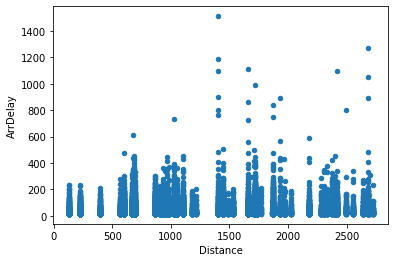

In [8]:
df_clear.plot(x= 'Distance', y='ArrDelay', kind = 'scatter');

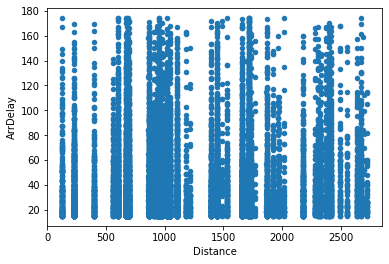

In [9]:
trial.plot(x= 'Distance', y='ArrDelay', kind = 'scatter');

# Continuation Of Main Code without removing Outliers

Standard Scaler to be used

In [23]:
X = df_clear.drop("ArrDelay", axis=1)
y = df_clear["ArrDelay"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [24]:
models = {}
models["DTR"] = DecisionTreeRegressor()
models["RR"] = RandomForestRegressor()
models["LR"] = LinearRegression()
models["GBR"] = GradientBoostingRegressor()

In [25]:
model_acc = {}
for key in models:
  model_r = models[key]
  dt = model_r.fit(X_train,y_train)
  a = model_r.score(X_test,y_test) 
  model_acc[key] = a
print(model_acc) 

{'DTR': 0.9841338201334644, 'RR': 0.9906722507045603, 'LR': 0.9999999731576268, 'GBR': 0.9866960650055971}


In [26]:
for key in models:
  model_r = models[key]
  dt = model_r.fit(X_train,y_train)
  pred = dt.predict(X_test) 
  mse=mean_squared_error(pred,y_test)
  rmse=sqrt(mse)
  print(model_r,rmse)

DecisionTreeRegressor() 9.336157360298378
RandomForestRegressor() 5.251728471477987
LinearRegression() 0.008915116337902864
GradientBoostingRegressor() 6.28005281448844


**With an R-Score of 0.999 and RMSE of 0.00892 LinearRegression works the best**

In [39]:
dt = LinearRegression().fit(X_train, y_train)

X_tail = X.tail(5)
print(y.tail(5))
print('{} mins'.format(dt.predict(X_tail).astype(int)))

1935383     46.0
1936455     16.0
1936674     30.0
1936676    106.0
1936717    135.0
Name: ArrDelay, dtype: float64
[ 45  16  29 105 134] mins


# Comparision of Normal Data and Data without Outliers and with Standard Scaling

In [30]:
X = trial.drop("ArrDelay", axis=1)
y = trial["ArrDelay"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler= StandardScaler().fit(X_train)
X_train_scaler= scaler.transform(X_train)
scaler= StandardScaler().fit(X_test)
X_test_scaler= scaler.transform(X_test)


print(X_train_scaler.mean(axis=0))
print(X_train_scaler.std(axis=0))
print(X_test_scaler.mean(axis=0))
print(X_test_scaler.std(axis=0))

[ 0.00000000e+00 -1.44725670e-17  5.15585198e-17 -1.20604725e-17
  1.89349418e-16 -2.13168851e-16  5.93978269e-17  6.79909136e-17
  2.41209449e-17  4.70358426e-17 -1.00704945e-16 -1.63419402e-16
  5.54781734e-17  1.20604725e-18 -7.47749293e-17 -1.01609481e-16
 -1.56786142e-17 -2.77390867e-17 -2.98496694e-17  1.38695433e-17
 -8.09559215e-17 -5.21615434e-17  1.62816378e-17 -2.41209449e-18
  3.73874647e-17  7.23628348e-17 -4.82418899e-18  2.02012914e-17
  3.28647875e-17  5.12570080e-18  6.03023624e-19 -2.44224568e-17
  3.07542048e-17  1.80907087e-17  3.01511812e-18 -9.04535435e-18
  1.80907087e-18 -2.05028032e-17 -6.03023624e-18 -3.34678111e-17
  7.65840002e-17  5.24630553e-17 -1.08544252e-17  2.41209449e-17
  3.97995592e-17  1.20604725e-17  0.00000000e+00 -6.99507403e-17
 -4.53775277e-17  6.03023624e-18 -1.92967560e-17 -9.64837798e-18
  3.85935119e-17  2.65330394e-17  2.59300158e-17  2.17088505e-17
  2.29148977e-17 -3.61814174e-17  7.62824884e-17  7.23628348e-18
  5.72872442e-18  4.37192

In [19]:
models1 = {}
models1["DTR"] = DecisionTreeRegressor()
models1["RR"] = RandomForestRegressor()
models1["LR"] = LinearRegression()
models1["GBR"] = GradientBoostingRegressor()
model_acc1 = {}
for key in models1:
  model_r1 = models1[key]
  dt1 = model_r1.fit(X_train_scaler,y_train)
  a1 = model_r1.score(X_test_scaler,y_test) 
  model_acc1[key] = a1
print(model_acc1) 
for key in models1:
  model_r1 = models1[key]
  dt1 = model_r1.fit(X_train_scaler,y_train)
  pred1 = dt1.predict(X_test_scaler) 
  mse1=mean_squared_error(pred1,y_test)
  rmse1=sqrt(mse1)
  print(model_r1,rmse1)

{'DTR': 0.9680249419758021, 'RR': 0.9829985456948759, 'LR': 0.996923078050663, 'GBR': 0.9734579953971526}
DecisionTreeRegressor() 5.985626347532665
RandomForestRegressor() 4.3065766561213685
LinearRegression() 1.8387766209082053
GradientBoostingRegressor() 5.400545052754588


R Score is the Goodness of Fit

In [33]:
dt1 = LinearRegression().fit(X_train_scaler, y_train)

X_tail1 = X.tail(5)
print(y.tail(5))
print('{} mins'.format(dt1.predict(X_tail1).astype(int)))

1935383     46.0
1936455     16.0
1936674     30.0
1936676    106.0
1936717    135.0
Name: ArrDelay, dtype: float64
[1200  457  785 2423 3697] mins


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#QQ-Plot for ArrDelay variable

In [20]:
from scipy.special import ndtri
plottingdf = df_clear.sort_values(by=["ArrDelay"], ascending = True).reset_index()
plottingdf['count']= plottingdf.index+1
n_rows = df.shape[0]
plottingdf['P_area'] = (plottingdf['count'])/n_rows
plottingdf['Z_theory'] = ndtri(plottingdf['P_area'])
plottingdf["Z_Actual"] = (plottingdf['ArrDelay']-plottingdf['ArrDelay'].mean())/plottingdf["ArrDelay"].std(ddof=0)

In [21]:
plottingdf.head()

,index,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TUS,count,P_area,Z_theory,Z_Actual
0,135779,2008,1,2,3,1246.0,1235,2006.0,1951,1108,...,0,0,0,0,0,0,1,8.016122e-07,-4.797919,-0.685331
1,794185,2008,5,29,4,1136.0,1120,1510.0,1455,876,...,0,0,0,0,0,0,2,1.603224e-06,-4.657132,-0.685331
2,1421449,2008,8,1,5,610.0,600,1225.0,1210,223,...,0,0,0,0,0,0,3,2.404837e-06,-4.572923,-0.685331
3,1804013,2008,12,16,2,1127.0,1104,1356.0,1341,6003,...,0,0,0,0,0,0,4,3.206449e-06,-4.512298,-0.685331
4,710062,2008,4,29,2,1206.0,1145,1752.0,1737,662,...,0,0,0,0,0,0,5,4.008061e-06,-4.464753,-0.685331


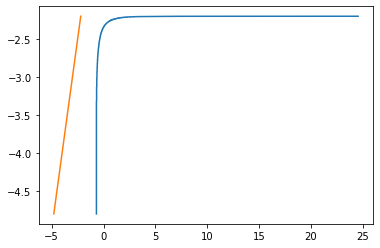

In [22]:
plt.plot(plottingdf.Z_Actual, plottingdf.Z_theory)
plt.plot(plottingdf.Z_theory,plottingdf.Z_theory)